In [ ]:
import pandas as pd
from google.colab import drive

def safe_load_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: The file at {file_path} was not found. Please check the path.")
        return None
    except Exception as e:
        print(f"An error occurred while loading the CSV: {e}")
        return None

drive.mount('/content/drive')
path = "/content/drive/MyDrive/datasets_2/"
final_path = path + "master_file2_preprocessed_small.csv"
df = safe_load_csv(final_path)

if df is not None:
    print("Final dataset loaded:", df.shape)
else:
    print("Failed to load dataset.")

Mounted at /content/drive
Final dataset loaded: (50000, 161)


In [ ]:
import numpy as np
from datetime import datetime

if "date_of_birth" in df.columns:
    df["date_of_birth"] = pd.to_datetime(df["date_of_birth"], errors='coerce')
    df["age"] = datetime.now().year - df["date_of_birth"].dt.year


In [ ]:
if "injury_reason" in df.columns:
    df["is_injured"] = df["injury_reason"].apply(lambda x: 0 if pd.isna(x) else 1)


In [ ]:
if ("goals" in df.columns) and ("appearances" in df.columns):
    df["goals_per_match"] = df["goals"] / (df["appearances"] + 1)


In [ ]:
numeric_cols = df.select_dtypes(include=['float64','int64']).columns

z = np.abs((df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std())
# df_no_outliers = df[(z < 3).all(axis=1)] # Original aggressive outlier removal

# Temporarily bypassing aggressive outlier removal to allow model training to proceed
df_no_outliers = df.copy()

print("After outlier removal:", df_no_outliers.shape)

After outlier removal: (50000, 161)


In [ ]:
target = "value"  # change if needed!

df_no_outliers = df_no_outliers.dropna(subset=[target])  # ensure no missing target

X = df_no_outliers.drop(columns=[target])
y = df_no_outliers[target]

print("Shapes:", X.shape, y.shape)

Shapes: (48693, 160) (48693,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (38954, 160)  Test: (9739, 160)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import numpy as np

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_imputed, y_train)

y_pred = lr.predict(X_test_imputed)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("----- Linear Regression Performance -----")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['player_name_y' 'text' 'vader_polarity' 'vader_emotion' 'tb_polarity'
 'tb_emotion' 'game_date' 'tweet_date' 'when']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['player_name_y' 'text' 'vader_polarity' 'vader_emotion' 'tb_polarity'
 'tb_emotion' 'game_date' 'tweet_date' 'when']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


----- Linear Regression Performance -----
MSE: 49156732348211.16
RMSE: 7011186.229748227
MAE: 2825116.8301904784
R²: 0.1516672078886694


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train_imputed)
X_test_poly = poly.transform(X_test_imputed)

model_poly_1 = LinearRegression()
model_poly_1.fit(X_train_poly, y_train)

y_pred_poly_1 = model_poly_1.predict(X_test_poly)
rmse_1 = np.sqrt(mean_squared_error(y_test, y_pred_poly_1))

print("Polynomial Degree 1 → RMSE:", rmse_1)


Polynomial Degree 1 → RMSE: 7011186.229744081


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: reduce features
# X_train_imputed is a numpy array, so select_dtypes is not applicable.
# We will directly select the first 20 columns from the imputed arrays.
X_train_small = X_train_imputed[:, :20]
X_test_small = X_test_imputed[:, :20]

print("Shapes:", X_train_small.shape, X_test_small.shape)

# Step 2: polynomial degree 2
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_small)
X_test_poly = poly.transform(X_test_small)

print("Poly shape:", X_train_poly.shape)

# Step 3: model
model_poly_2 = LinearRegression()
model_poly_2.fit(X_train_poly, y_train)

y_pred = model_poly_2.predict(X_test_poly)
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred))

print("Degree 2 RMSE:", rmse_2)


Shapes: (38954, 20) (9739, 20)
Poly shape: (38954, 231)
Degree 2 RMSE: 7189956.039213703


In [ ]:
# X_train_imputed is a numpy array, so select_dtypes is not applicable.
# We will directly select the first 10 columns from the imputed arrays.
selected_cols = X_train_imputed[:, :10]

X_train_small = selected_cols
X_test_small = X_test_imputed[:, :10]

print("Using the first 10 features.")
print("Shapes:", X_train_small.shape, X_test_small.shape)

Using the first 10 features.
Shapes: (38954, 10) (9739, 10)


In [ ]:
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train_small)
X_test_poly = poly.transform(X_test_small)

model_poly_3 = LinearRegression()
model_poly_3.fit(X_train_poly, y_train)

y_pred_poly_3 = model_poly_3.predict(X_test_poly)
rmse_3 = np.sqrt(mean_squared_error(y_test, y_pred_poly_3))

print("Polynomial Degree 3 → RMSE:", rmse_3)


Polynomial Degree 3 → RMSE: 7190105.800846882


In [ ]:
poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X_train_small)
X_test_poly = poly.transform(X_test_small)

model_poly_4 = LinearRegression()
model_poly_4.fit(X_train_poly, y_train)

y_pred_poly_4 = model_poly_4.predict(X_test_poly)
rmse_4 = np.sqrt(mean_squared_error(y_test, y_pred_poly_4))

print("Polynomial Degree 4 → RMSE:", rmse_4)


Polynomial Degree 4 → RMSE: 7495857.152712039


In [ ]:
poly = PolynomialFeatures(degree=5)
X_train_poly = poly.fit_transform(X_train_small)
X_test_poly = poly.transform(X_test_small)

model_poly_5 = LinearRegression()
model_poly_5.fit(X_train_poly, y_train)

y_pred_poly_5 = model_poly_5.predict(X_test_poly)
rmse_5 = np.sqrt(mean_squared_error(y_test, y_pred_poly_5))

print("Polynomial Degree 5 → RMSE:", rmse_5)


Polynomial Degree 5 → RMSE: 29914651.913857523


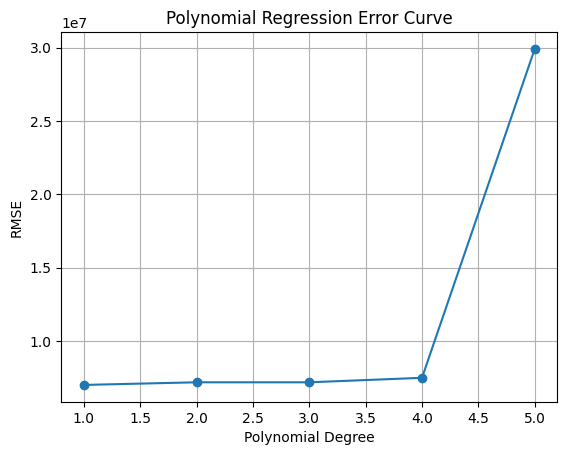

In [ ]:
import matplotlib.pyplot as plt

degrees = [1, 2, 3, 4, 5]
errors = [rmse_1, rmse_2, rmse_3, rmse_4, rmse_5]

plt.plot(degrees, errors, marker='o')
plt.xlabel("Polynomial Degree")
plt.ylabel("RMSE")
plt.title("Polynomial Regression Error Curve")
plt.grid(True)
plt.show()

In [ ]:
# ===== Fix preprocessing issues + run safe RF and LGB baselines =====
import numpy as np, pandas as pd, joblib, time
from scipy import sparse
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import lightgbm # Added import for lightgbm module
warnings.filterwarnings("ignore")

# Assumes df_no_outliers exists
df = df_no_outliers.copy()

TARGET = "value"
# 1) Drop ID columns if exist
for c in ["player_id", "date_unix", "Unnamed: 0"]:
    if c in df.columns: df.drop(columns=c, inplace=True)

# 2) Drop columns with ALL missing values (they cause the imputer warnings)
all_null_cols = df.columns[df.isna().all()].tolist()
print("Columns with all-null (dropping):", all_null_cols)
df.drop(columns=all_null_cols, inplace=True)

# 3) If there are non-numeric columns that you intended as categorical, ensure they are object dtype.
#    We'll auto-detect again.
X = df.drop(columns=[TARGET])
y = df[TARGET].values

# Convert boolean columns to object dtype to be correctly handled as categories by imputer
for col in X.select_dtypes(include=['bool']).columns:
    X[col] = X[col].astype(str)

# Recompute numeric/categorical split safely
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("NUM cols:", len(num_cols), "CAT cols:", len(cat_cols))

# If you have text columns you don't want encoded (tweet text etc), drop them explicitly:
text_like = [c for c in X.columns if c.lower() in ("text","tweet_text","tweet_date","game_date","player_name_y")]
print("Text-like columns (drop if present):", text_like)
# drop them (you can keep them and extract features later, but drop for now)
for c in text_like:
    if c in X.columns:
        X = X.drop(columns=c)
        if c in num_cols: num_cols.remove(c)
        if c in cat_cols: cat_cols.remove(c)

# Recreate train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)

# 4) Rebuild a small preprocessor (median imputer for numeric; frequent for cat; OHE with sparse)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

TOP_K = 30
# cap top-K categories
for c in cat_cols:
    topk = X_train[c].value_counts().nlargest(TOP_K).index
    X_train[c] = X_train[c].where(X_train[c].isin(topk), other="__OTHER__")
    X_test[c]  = X_test[c].where(X_test[c].isin(topk), other="__OTHER__")

num_transformer = Pipeline([("imputer", SimpleImputer(strategy="median"))])
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True)) # FIX: Changed 'sparse=True' to 'sparse_output=True'
])
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
], remainder='drop')

# Fit once and transform
preprocessor.fit(X_train)
X_train_trans = preprocessor.transform(X_train)
X_test_trans  = preprocessor.transform(X_test)

# Convert to CSR sparse (if not)
if not sparse.isspmatrix_csr(X_train_trans):
    X_train_trans = sparse.csr_matrix(X_train_trans)
if not sparse.isspmatrix_csr(X_test_trans):
    X_test_trans = sparse.csr_matrix(X_test_trans)

print("Transformed shapes:", X_train_trans.shape, X_test_trans.shape)

# 5) Baseline Random Forest (no search) -- uses modest defaults to ensure it runs fast
rf = RandomForestRegressor(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
t0 = time.time()
# convert to dense if small (ours: 38954 x 149 -> dense ok)
X_train_rf = X_train_trans.toarray() if sparse.isspmatrix(X_train_trans) else X_train_trans
X_test_rf  = X_test_trans.toarray()  if sparse.isspmatrix(X_test_trans) else X_test_trans
rf.fit(X_train_rf, y_train)
print("RF baseline fit time: %.2fs" % (time.time()-t0))
y_rf = rf.predict(X_test_rf)
print("RF baseline RMSE:", np.sqrt(mean_squared_error(y_test, y_rf)), "R2:", r2_score(y_test, y_rf))

# 6) Baseline LightGBM (no search)
lgb = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=10, n_jobs=-1, random_state=42)
t0 = time.time()
# LightGBM accepts sparse; pass sparse if available
lgb.fit(X_train_trans, y_train, eval_set=[(X_test_trans, y_test)], eval_metric='rmse', callbacks=[lightgbm.early_stopping(50, verbose=False)]) # Fixed early stopping
print("LGB baseline fit time: %.2fs" % (time.time()-t0))
y_lgb = lgb.predict(X_test_trans)
print("LGB baseline RMSE:", np.sqrt(mean_squared_error(y_test, y_lgb)), "R2:", r2_score(y_test, y_lgb))

# 7) Quick RandomizedSearch on a SMALL SUBSET to tune RF and LGB safely
#    We'll sample 10k rows from training to speed up the search
sample_n = min(10000, X_train_rf.shape[0])
idx = np.random.RandomState(1).choice(np.arange(X_train_rf.shape[0]), size=sample_n, replace=False)
X_train_sub = X_train_rf[idx]
y_train_sub = y_train[idx]

# RF randomized search (small)
from sklearn.model_selection import RandomizedSearchCV
rf_params = {
    "n_estimators": [100, 150, 250],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10]
}
rf_search = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                               rf_params, n_iter=6, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=1)
t0 = time.time()
rf_search.fit(X_train_sub, y_train_sub)
print("RF search time (subset): %.2fs" % (time.time()-t0))
print("RF best params:", rf_search.best_params_)
best_rf = rf_search.best_estimator_
y_brf = best_rf.predict(X_test_rf)
print("RF tuned RMSE:", np.sqrt(mean_squared_error(y_test, y_brf)), "R2:", r2_score(y_test, y_brf))

# LGB randomized search (small, on sparse)
lgb_params = {
    "n_estimators": [100,200,400],
    "max_depth": [6,10,15,-1],
    "learning_rate": [0.01, 0.05, 0.1]
}
lgb_search = RandomizedSearchCV(LGBMRegressor(n_jobs=-1, random_state=42),
                                lgb_params, n_iter=6, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=2)
t0 = time.time()
# use sparse for LGB
lgb_search.fit(X_train_trans[idx], y_train_sub)
print("LGB search time (subset): %.2fs" % (time.time()-t0))
print("LGB best params:", lgb_search.best_params_)
best_lgb = lgb_search.best_estimator_
y_blgb = best_lgb.predict(X_test_trans)
print("LGB tuned RMSE:", np.sqrt(mean_squared_error(y_test, y_blgb)), "R2:", r2_score(y_test, y_blgb))

# 8) Save best models if you want
joblib.dump(best_rf, "/content/drive/MyDrive/datasets_2/models_opt_no_lasso/best_rf_small_search.joblib")
joblib.dump(best_lgb, "/content/drive/MyDrive/datasets_2/models_opt_no_lasso/best_lgb_small_search.joblib")

print("Done: baseline + small searches finished.")

Columns with all-null (dropping): ['player_name_y', 'text', 'vader_polarity', 'vader_emotion', 'tb_polarity', 'tb_emotion', 'game_date', 'tweet_date', 'when']
NUM cols: 149 CAT cols: 1
Text-like columns (drop if present): []
Train: (38954, 150) Test: (9739, 150)
Transformed shapes: (38954, 151) (9739, 151)
RF baseline fit time: 108.52s
RF baseline RMSE: 2670498.011827832 R2: 0.8769255887236677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 38954, number of used features: 106
[LightGBM] [Info] Start training from score 2017472.018278
LGB baseline fit time: 10.69s
LGB baseline RMSE: 3880125.631690931 R2: 0.740178656511445
RF search time (subset): 443.96s
RF best params: {'n_estimators': 150, 'min_samples_split': 2, 'max_d